In [1]:
import igraph as ig
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from sklearn.metrics import adjusted_mutual_info_score as AMI
from sklearn.metrics import roc_auc_score as AUC
from sklearn.metrics import roc_curve
from tqdm import trange, tqdm

from itertools import product
import sys
import os
sys.path.append('../')
from CAS import *

import ECG.ecg_sknetwork as ecg_sknetwork
import ecg_igraph as ecg_igraph

In [2]:
def compute_edge_weights(G, cas, clusters, combine_function="min", normalize=True):
        source_to_target = np.empty(G.ecount())
        target_to_source = np.empty(G.ecount())
        for i, e in enumerate(G.es):
                target_clusters = clusters.indices[clusters.indptr[e.target]:clusters.indptr[e.target+1]]
                if len(target_clusters) == 0:
                        source_to_target[i] = 0
                else:
                        source_to_target[i] = np.max([cas[e.source, target_cluster] for target_cluster in target_clusters])

                source_clusters = clusters.indices[clusters.indptr[e.source]:clusters.indptr[e.source+1]]
                if len(source_clusters) == 0:
                        target_to_source[i] = 0
                else:
                        target_to_source[i] = np.max([cas[e.source, source_cluster] for source_cluster in source_clusters])

        if combine_function=="min":
                weights = np.minimum(source_to_target, target_to_source)
        elif combine_function=="prod":
               weights = source_to_target * target_to_source
        elif combine_function=="mean":
                weights = (source_to_target + target_to_source)/2
        else:
               raise ValueError(f"combine_function must be one of min, prod, mean. Got {combine_function}")
        
        if normalize:
               return weights / (np.max(weights) - np.min(weights))
        return weights


def cas_edge_weights(G, clusters, combine_function="min", normalize=True):
        graph_matrix = G.get_adjacency_sparse()
        ief, beta, c, p, degs = CAS(graph_matrix, clusters)

        ief_weights = compute_edge_weights(G, ief, clusters, combine_function=combine_function, normalize=normalize)
        beta_weights = compute_edge_weights(G, beta, clusters, combine_function=combine_function, normalize=normalize)
        c_weights = compute_edge_weights(G, c, clusters, combine_function=combine_function, normalize=normalize)
        p_weights = compute_edge_weights(G, p, clusters, combine_function=combine_function, normalize=normalize)

        ecg_weights = compute_edge_weights(G, clusters, clusters, combine_function=combine_function, normalize=False)
        
        return ief_weights, beta_weights, c_weights, p_weights, ecg_weights


def ensemble_cas_edge_weights(G, ens_size=16, combine_function="min", normalize=True, clustering_method="first_louvain", resolution=0.1):
        ief_weights = np.zeros(G.ecount())
        beta_weights = np.zeros(G.ecount())
        c_weights = np.zeros(G.ecount())
        p_weights = np.zeros(G.ecount())
        ecg_weights = np.zeros(G.ecount())

        for _ in range(ens_size):
                permutation = np.random.permutation(G.vcount())
                g = G.permute_vertices(permutation)
                if clustering_method == "leiden":
                        clustering = np.array(g.community_leiden(resolution=resolution).membership)
                elif clustering_method == "louvain":
                        clustering = np.array(g.community_louvain(resolution=resolution).membership)
                elif clustering_method == "first_louvain":
                        clustering = np.array(g.community_multilevel(return_levels=True)[0].membership)
                else:
                        raise ValueError(f"clustering_method expected one of leiden, louvain, or first_louvain. Got {clustering_method}")
                
                clustering = partition2sparse(clustering)
                ief, beta, c, p, ecg = cas_edge_weights(g, clustering, combine_function=combine_function, normalize=normalize)

                ief_weights += ief
                beta_weights += beta
                c_weights += c
                p_weights += p
                ecg_weights += ecg

        return ief_weights/ens_size, beta_weights/ens_size, c_weights/ens_size, p_weights/ens_size, ecg_weights/ens_size


def cluster_edges(G, edge_weights, min_weight=0.05, twocore=True, final="leiden", resolution=1.0):
        if min_weight > 0:
                edge_weights = (1-min_weight) * edge_weights + min_weight
        
        if twocore:
                core = G.shell_index()
                ecore = np.array([min(core[e.source],core[e.target]) for e in G.es])
                edge_weights[ecore == 1] = min_weight

        if final == "leiden":
                return G.community_leiden(weights=edge_weights, objective_function='modularity', resolution=resolution)
        elif final == "louvain":
                return G.community_multilevel(weights=edge_weights)
        else:
                raise ValueError(f"final expected one of leiden or louvain. Got {final}")


def outlier_scores(G, edge_weights, clustering):
        degs = np.array(G.degree())
        good = np.zeros(G.vcount())
        bad = np.zeros(G.vcount())
        for i, e in enumerate(G.es):
                if clustering[e.source] == clustering[e.target]:
                      good[e.source] += edge_weights[i]
                      good[e.target] += edge_weights[i]
                else:
                      bad[e.source] += edge_weights[i]
                      bad[e.target] += edge_weights[i]       
        
        overall = (degs - bad - good)/degs
        community = bad/(bad + good)
        return overall, community

In [2]:
def community_ecg(self, weights=None, ens_size = 16, min_weight = 0.05, 
                  final='louvain', resolution=1.0, refuse_score=False):
    """
    Stable ensemble-based graph clustering;
    the ensemble consists of single-level randomized Louvain; 
    each member of the ensemble gets a "vote" to determine if the edges 
    are intra-community or not;
    the votes are aggregated into ECG edge-weights in range [0,1]; 
    a final (full depth) Louvain is run using those edge weights;
    
    Parameters
    ----------
    self: graph of type 'igraph.Graph'
      Graph to define the partition on.
    weights: list of double, optional 
      the edge weights
    ens_size: int, optional
      the size of the ensemble of single-level Louvain
    min_weight: double in range [0,1], optional
      the ECG edge weight for edges with zero votes from the ensemble
    final: 'louvain' (default) or 'leiden'
      the algorithm to run on the final re-weighted graph
    resolution: positive float, optional
      resolution parameter; larger values favors smaller communities
      
    Returns
    -------
    partition
      The final partition, of type 'igraph.clustering.VertexClustering'
    partition.W
      The ECG edge weights
    partition.CSI
      The community strength index
    partition.original_modularity
      The modularity with respect to the original edge weights

    Notes
    -----
    The ECG edge weight function is defined as:
      
      min_weight + ( 1 - min_weight ) x (#votes_in_ensemble) / ens_size
      
    Edges outside the 2-core are assigned 'min_weight'.
    
    Examples
    --------
    >>> g = igraph.Graph.Famous('Zachary')
    >>> part = g.community_ecg(ens_size=25, min_weight = .1)
    >>> print(part.CSI)
    
    Reference
    ---------
    Valérie Poulin and François Théberge, "Ensemble clustering for graphs: comparisons and applications", Appl Netw Sci 4, 51 (2019). 
    https://doi.org/10.1007/s41109-019-0162-z
    """
    W = [0]*self.ecount()
    ## Ensemble of level-1 Louvain
    for i in range(ens_size):
        p = np.random.permutation(self.vcount()).tolist()
        g = self.permute_vertices(p)
        l1 = g.community_multilevel(weights=weights, return_levels=True)[0].membership
        b = [l1[p[x.tuple[0]]]==l1[p[x.tuple[1]]] for x in self.es]
        W = [W[i]+b[i] for i in range(len(W))]
    W = [min_weight + (1-min_weight)*W[i]/ens_size for i in range(len(W))]
    ## Force min_weight outside 2-core
    core = self.shell_index()
    ecore = [min(core[x.tuple[0]],core[x.tuple[1]]) for x in self.es]
    w = [W[i] if ecore[i]>1 else min_weight for i in range(len(ecore))]
    if final=='leiden':
        part = self.community_leiden(weights=w, objective_function='modularity', resolution=resolution)
    else:
        part = self.community_multilevel(weights=w, resolution=resolution)
    part.W = W
    part.CSI = 1-2*np.sum([min(1-i,i) for i in W])/len(W)
    part._modularity_params['weights'] = weights
    part.recalculate_modularity()
    
    ## experimental - "refuse to cluster" scores
    if refuse_score:
        self.vs['_deg'] = self.degree()
        self.es['_W'] = part.W
        self.vs['_ecg'] = part.membership
        for v in self.vs:
            scr = 0
            my_comm = v['_ecg']
            good = 0
            bad = 0
            for e in v.incident():
                scr += e['_W']
                if self.vs[e.source]['_ecg'] == self.vs[e.target]['_ecg']:
                    good += e['_W']
                else:
                    bad += e['_W']
            v['_overall'] = ((v['_deg']-scr)/v['_deg'])
            v['_community'] = (bad/(bad+good))        
        part.refuse_overall = self.vs['_overall']
        part.refuse_community = self.vs['_community']
        del(self.vs['_deg'])
        del(self.es['_W'])
        del(self.vs['_ecg'])
        del(self.vs['_overall'])
        del(self.vs['_community'])            
    ## end experimental scores
    
    return part

ig.Graph.community_ecg = community_ecg

## Code to generate ABCD-o graphs (currently requires julia)

In [3]:
# ABCD+o only in Julia for now - update path below as needed

## local:
# abcd_path = '/Users/francois/ABCD/ABCDo/ABCDGraphGenerator.jl/utils/'
# julia = '/Applications/Julia-1.7.app/Contents/Resources/julia/bin/julia '

## Dev02:
abcd_path = '/home/rdewolfe/research/ABCDGraphGenerator.jl/utils/'
julia = '/home/rdewolfe/.juliaup/bin/julia '

def _run_julia_abcd(n=1000, xi=0.3, delta=5, zeta=0.5, gamma=2.5, s=25, tau=0.825, beta=1.5, seed=123, nout=0):
    D = int(n**zeta)
    S = int(n**tau) 
    rdm = str(np.random.choice(100000))
    fn_deg = 'deg_'+rdm+'.dat'
    fn_cs = 'cs_'+rdm+'.dat'
    fn_comm = 'comm_'+rdm+'.dat'
    fn_net = 'net_'+rdm+'.dat'
    ## generate graph
    cmd = julia+abcd_path+'deg_sampler.jl '+fn_deg+' '+str(gamma)+' '+str(delta)+' '+str(D)+' '+str(n)+' 1000 '+str(seed)
    os.system(cmd+' >/dev/null 2>&1')
    cmd = julia+abcd_path+'com_sampler.jl '+fn_cs+' '+str(beta)+' '+str(s)+' '+str(S)+' '+str(n)+' 1000 '+str(seed)+' '+str(nout)
    os.system(cmd+' >/dev/null 2>&1')
    cmd = julia+abcd_path+'graph_sampler.jl '+fn_net+' '+fn_comm+' '+fn_deg+' '+fn_cs+' xi '+str(xi)+' false false '+str(seed)+' '+str(nout)
    os.system(cmd+' >/dev/null 2>&1')
    g = ig.Graph.Read_Ncol(fn_net,directed=False)
    c = np.loadtxt(fn_comm,dtype='uint16',usecols=(1))
    ## ground-truth communities
    gt = [c[int(i['name'])-1]-1 for i in g.vs]
    g.vs['gt'] = gt
    cmd = 'rm *_'+rdm+'.dat'
    os.system(cmd+' >/dev/null 2>&1')
    return g

## Test if CAS scores can weight edges well using ground truth communities

100%|██████████| 5/5 [00:51<00:00, 10.23s/it]


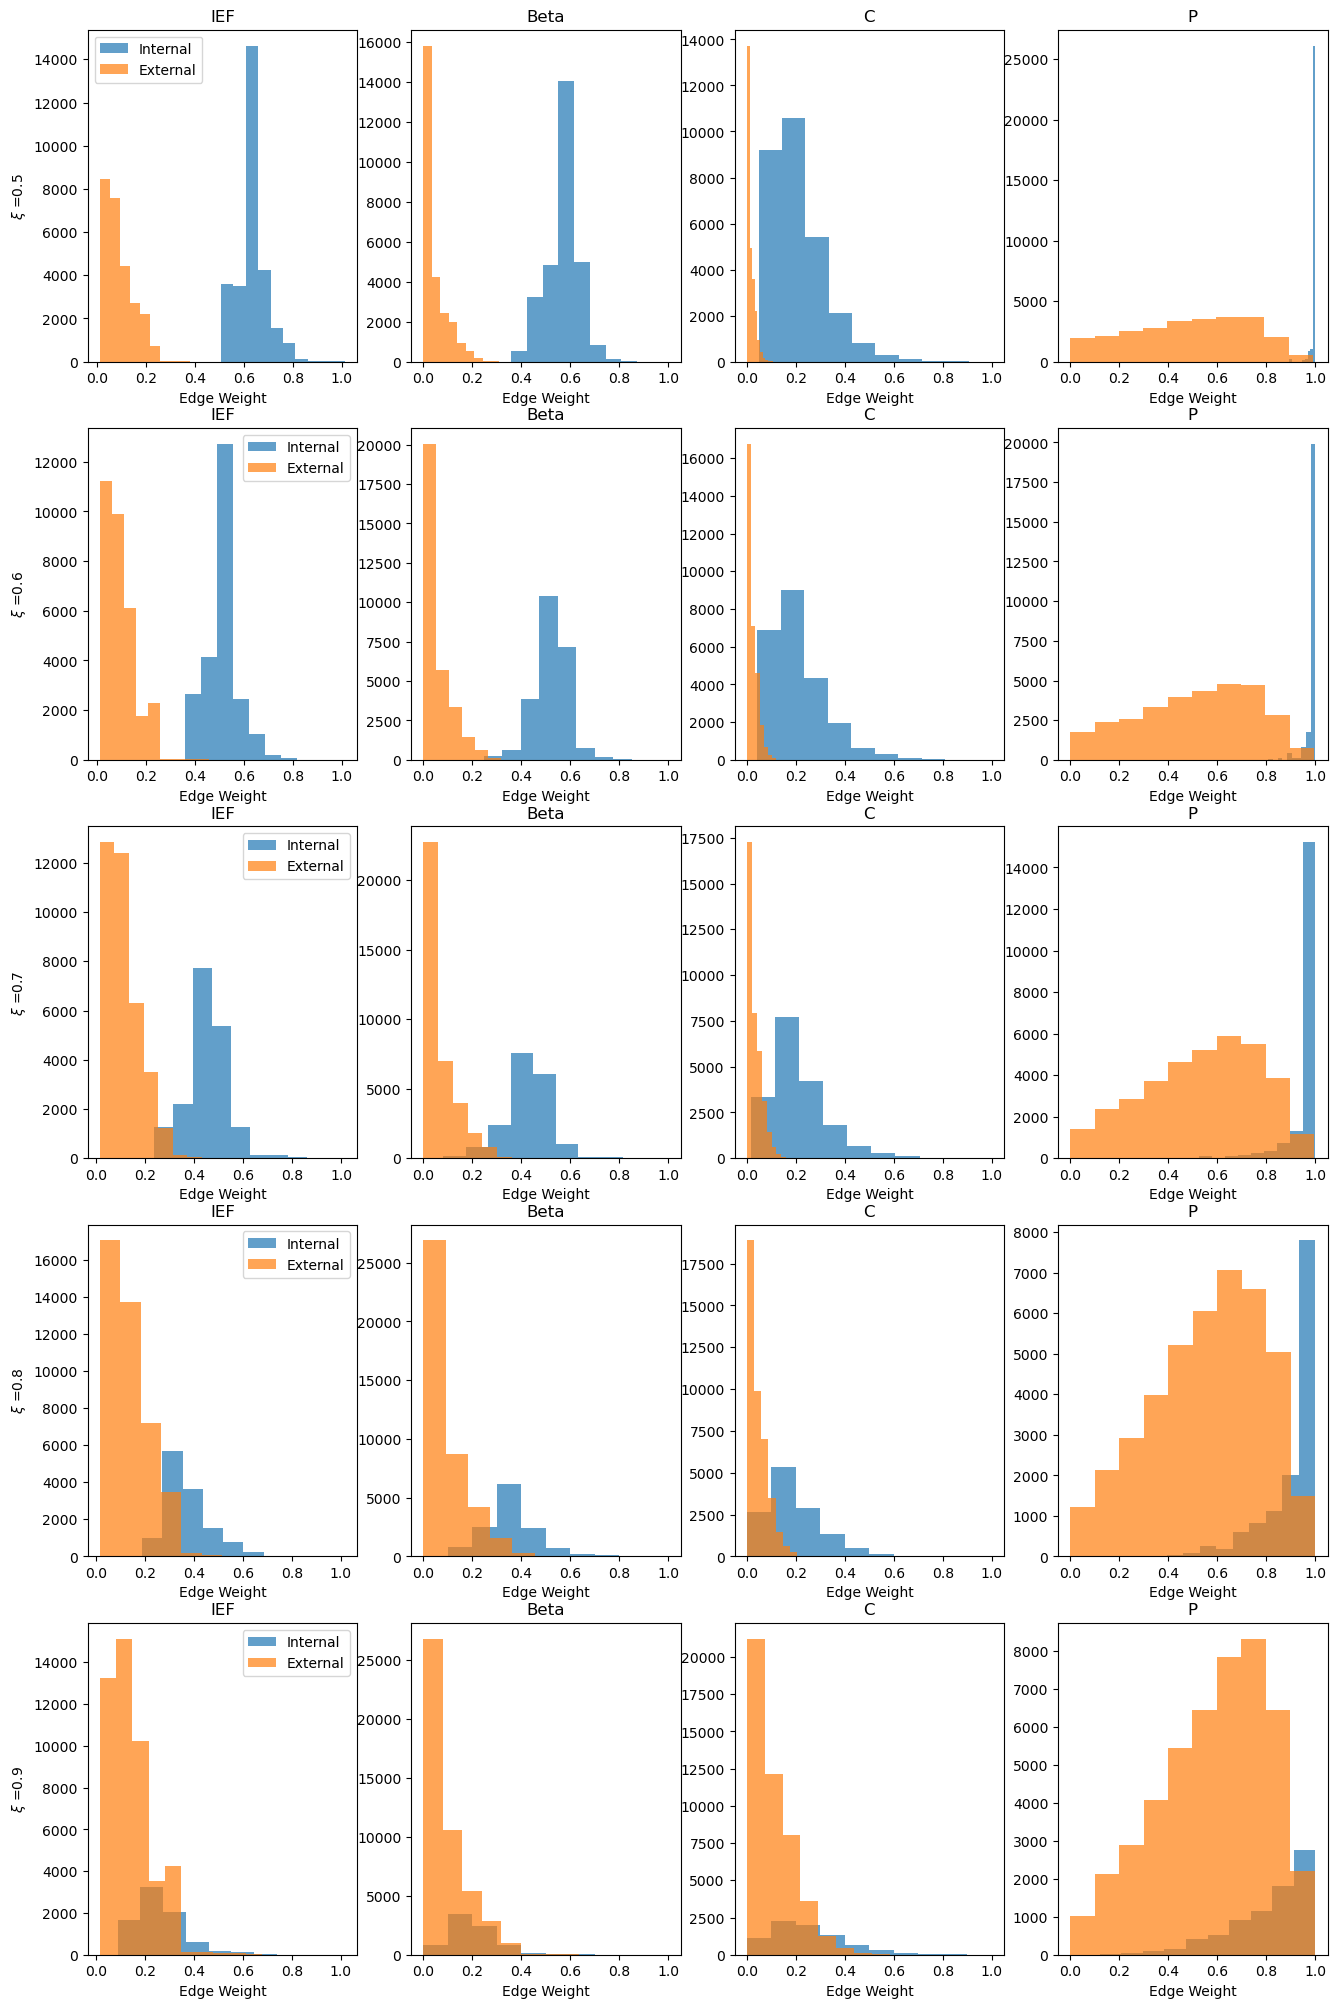

In [6]:
## first with "mid-size" graphs
num_nodes = 10000
num_out = 0
delta = 5
min_comm = 100
alpha = 1


XIs = [.5, .6, .7, .8, .9]
fig, axs = plt.subplots(len(XIs), 4, figsize=(16, 5*len(XIs)))
for i in trange(len(XIs)):
    xi = XIs[i]
    g = _run_julia_abcd(n=num_nodes, xi=xi, delta=delta, gamma=2.5, beta=1.5, 
                            zeta = 0.5, s=min_comm, tau = 0.767, nout=num_out)

    gt = np.array(g.vs["gt"])
    ief, beta, c, p, ecg = ecg_igraph.cas_edge_weights(g, gt)
    is_internal = np.array([g.vs[e.source]["gt"] == g.vs[e.target]["gt"] for e in g.es], dtype="bool")

    axs[i,0].hist(ief[is_internal == True], label="Internal", alpha=0.7)
    axs[i, 0].hist(ief[is_internal == False], label="External", alpha=0.7)
    axs[i, 0].set_xlabel("Edge Weight")
    axs[i, 0].set_title("IEF")
    axs[i, 0].legend()
    axs[i, 0].set_ylabel(r'$\xi$ ='+str(xi))

    axs[i, 1].hist(beta[is_internal == True], label="Internal", alpha=0.7)
    axs[i, 1].hist(beta[is_internal == False], label="External", alpha=0.7)
    axs[i, 1].set_xlabel("Edge Weight")
    axs[i, 1].set_title("Beta")

    axs[i, 2].hist(c[is_internal == True], label="Internal", alpha=0.7)
    axs[i, 2].hist(c[is_internal == False], label="External", alpha=0.7)
    axs[i, 2].set_xlabel("Edge Weight")
    axs[i, 2].set_title("C")

    axs[i, 3].hist(p[is_internal == True], label="Internal", alpha=0.7)
    axs[i, 3].hist(p[is_internal == False], label="External", alpha=0.7)
    axs[i, 3].set_xlabel("Edge Weight")
    axs[i, 3].set_title(f"P")


100%|██████████| 9/9 [01:31<00:00, 10.21s/it]


Text(0.5, 0.98, 'CAS-ECG ground truth ROC curves')

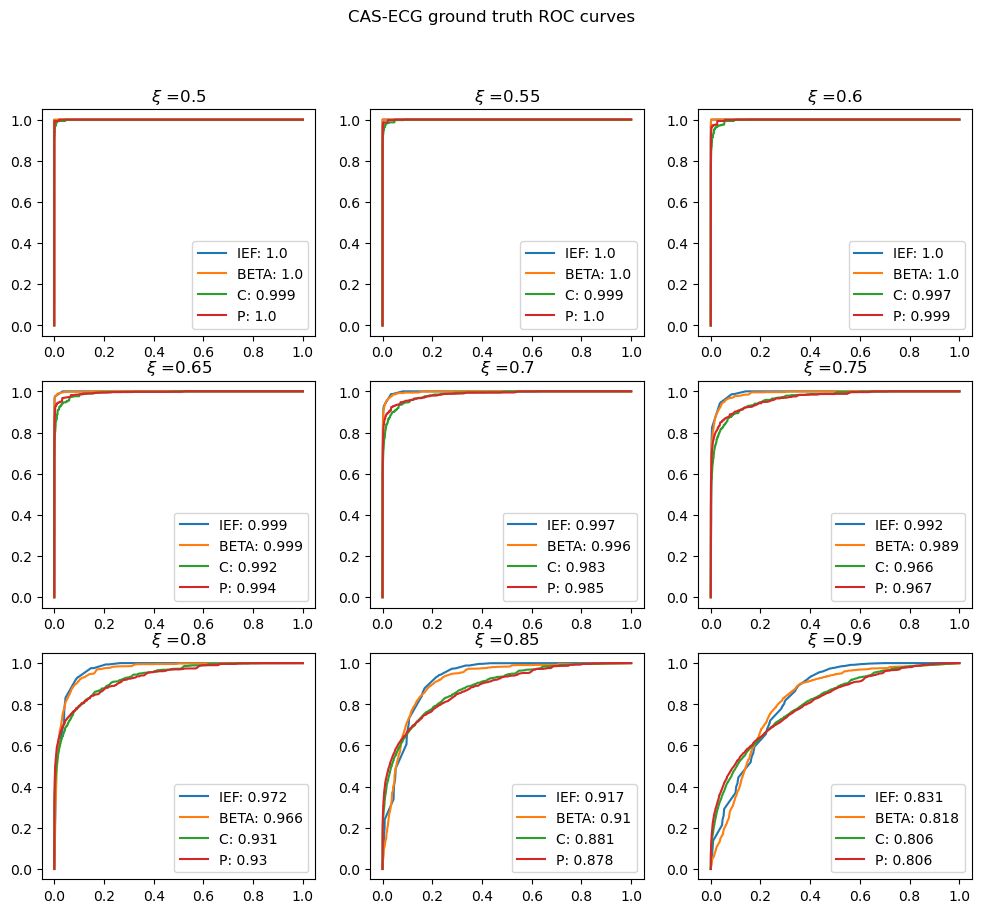

In [9]:
# AUCROC curves for edge weight predicting is-internal
XIs = [.5, .55, .6, .65, .7, .75, .8, .85, .9]
fig, axs = plt.subplots(3, 3, figsize=(12, 10))
for i in trange(len(XIs)):
    xi = XIs[i]
    plt.subplot(3,3,i+1)
    g = _run_julia_abcd(n=num_nodes, xi=xi, delta=delta, gamma=2.5, beta=1.5, zeta = 0.5, s=min_comm, tau = 0.767, nout=num_out)

    gt = np.array(g.vs["gt"])
    ief, beta, c, p, ecg = ecg_igraph.cas_edge_weights(g, gt)
    is_internal = np.array([g.vs[e.source]["gt"] == g.vs[e.target]["gt"] for e in g.es], dtype="bool")

    fpr, tpr, thresholds = roc_curve(is_internal, ief, pos_label=1)
    plt.plot(fpr, tpr, label='IEF: '+str(round(AUC(is_internal, ief),3)))

    fpr, tpr, thresholds = roc_curve(is_internal, beta, pos_label=1)
    plt.plot(fpr, tpr, label='BETA: '+str(round(AUC(is_internal, beta),3)))

    fpr, tpr, thresholds = roc_curve(is_internal, c, pos_label=1)
    plt.plot(fpr, tpr, label='C: '+str(round(AUC(is_internal, c),3)))

    fpr, tpr, thresholds = roc_curve(is_internal, p, pos_label=1)
    plt.plot(fpr, tpr, label='P: '+str(round(AUC(is_internal, p),3)))

    plt.title(r'$\xi$ ='+str(xi))
    plt.legend()
    

plt.suptitle("CAS-ECG ground truth ROC curves")

## Test if the Ensemble edge-weights can perform similarily

100%|██████████| 5/5 [07:35<00:00, 91.05s/it]


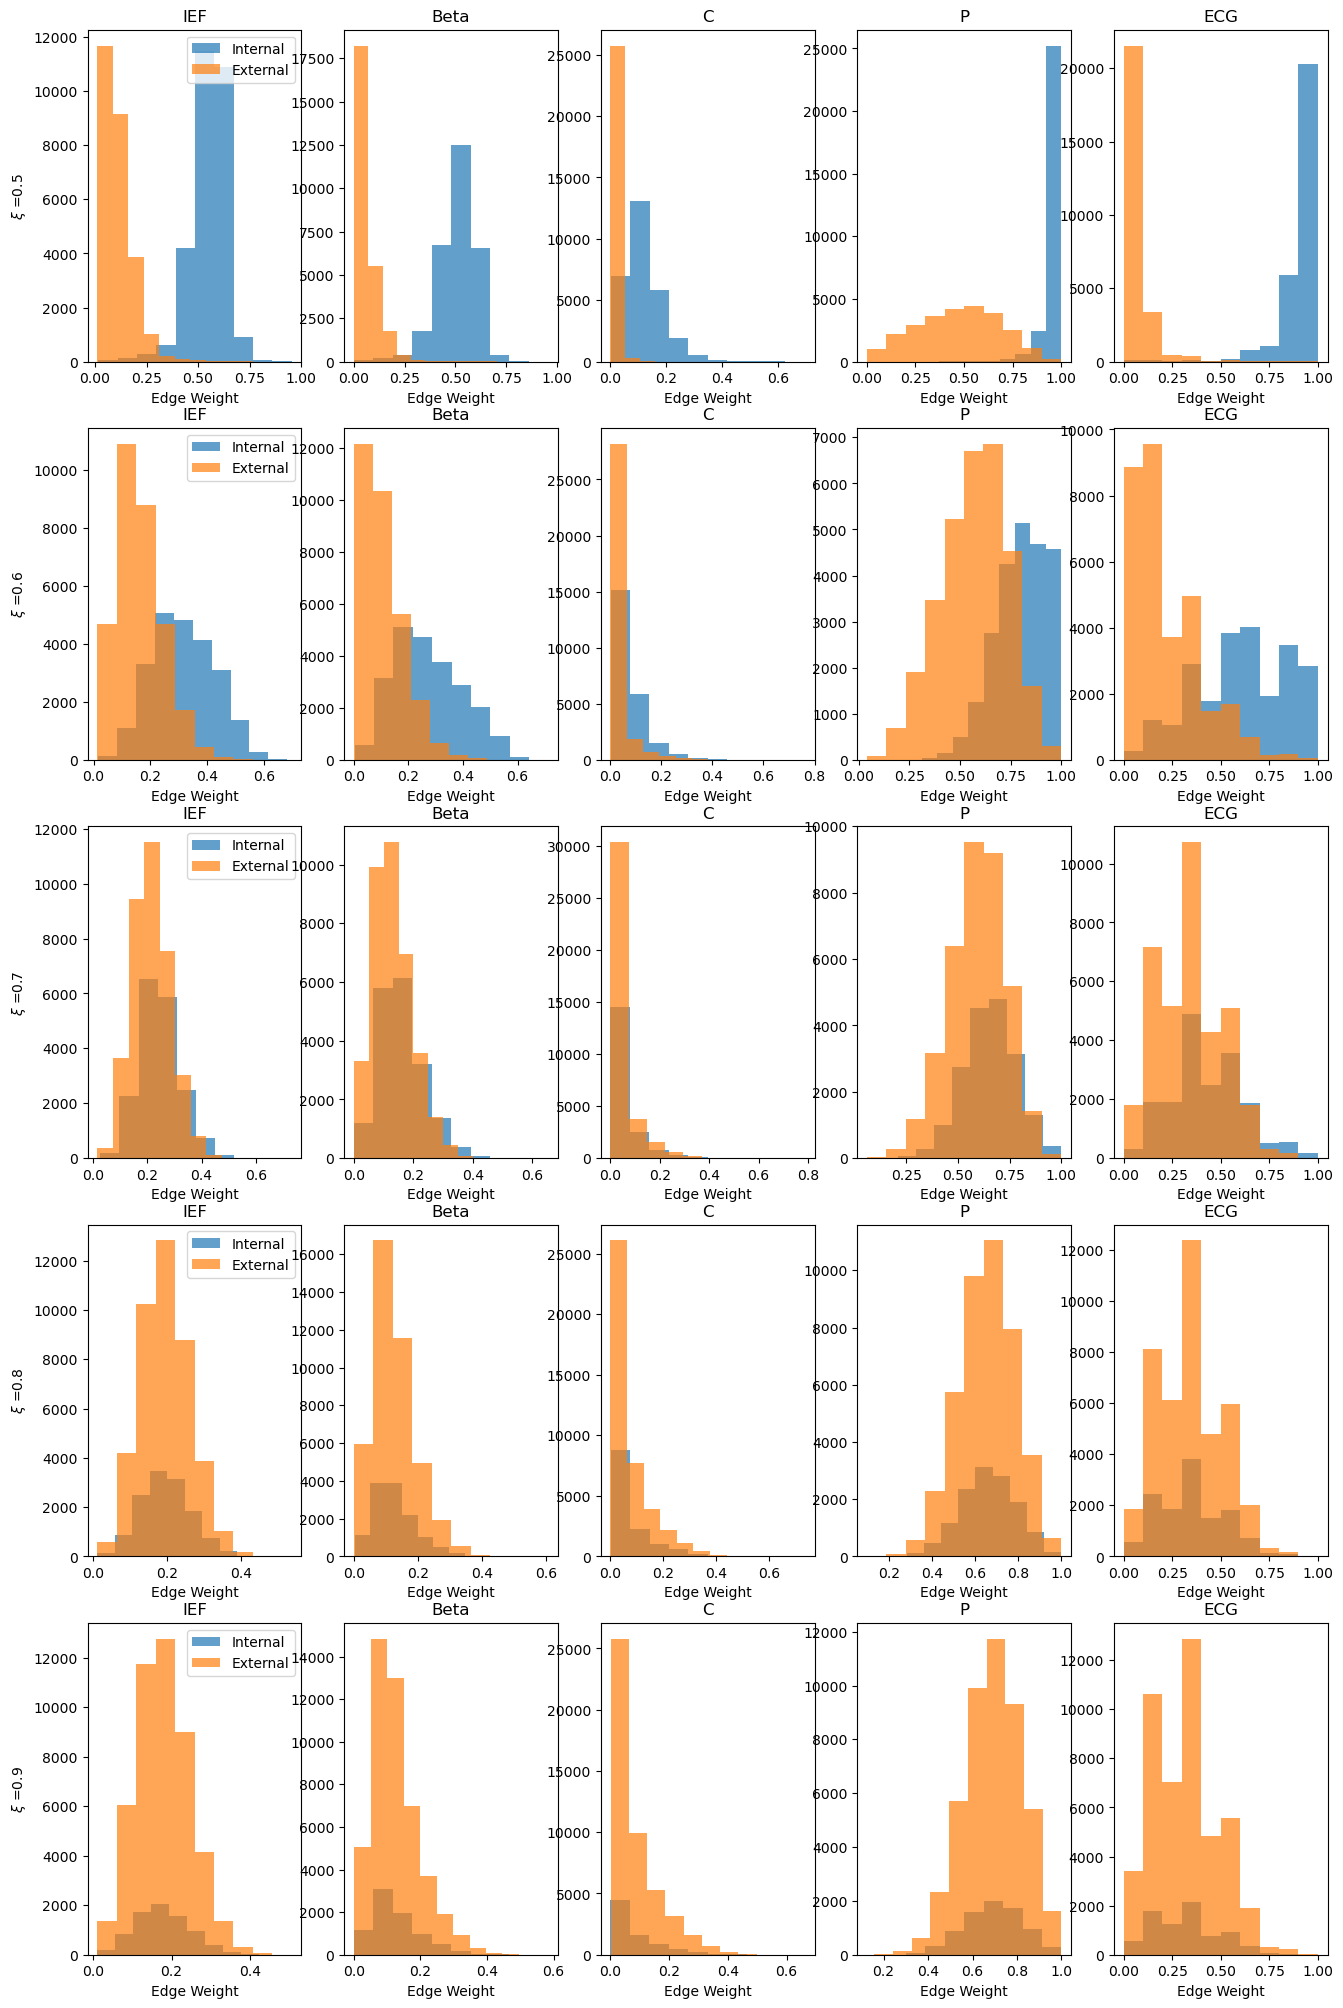

In [10]:
## first with "mid-size" graphs
num_nodes = 10000
num_out = 0
delta = 5
min_comm = 100
alpha = 1


XIs = [.5, .6, .7, .8, .9]
fig, axs = plt.subplots(len(XIs), 5, figsize=(16, 5*len(XIs)))
for i in trange(len(XIs)):
    xi = XIs[i]
    g = _run_julia_abcd(n=num_nodes, xi=xi, delta=delta, gamma=2.5, beta=1.5, zeta = 0.5, s=min_comm, tau = 0.767, nout=num_out)

    ief, beta, c, p, ecg = ecg_igraph.ensemble_cas_edge_weights(g, combine_function="min", resolution=0.05, clustering_method="first_louvain")
    is_internal = np.array([g.vs[e.source]["gt"] == g.vs[e.target]["gt"] for e in g.es], dtype="bool")

    axs[i,0].hist(ief[is_internal == True], label="Internal", alpha=0.7)
    axs[i, 0].hist(ief[is_internal == False], label="External", alpha=0.7)
    axs[i, 0].set_xlabel("Edge Weight")
    axs[i, 0].set_title("IEF")
    axs[i, 0].legend()
    axs[i, 0].set_ylabel(r'$\xi$ ='+str(xi))

    axs[i, 1].hist(beta[is_internal == True], label="Internal", alpha=0.7)
    axs[i, 1].hist(beta[is_internal == False], label="External", alpha=0.7)
    axs[i, 1].set_xlabel("Edge Weight")
    axs[i, 1].set_title("Beta")

    axs[i, 2].hist(c[is_internal == True], label="Internal", alpha=0.7)
    axs[i, 2].hist(c[is_internal == False], label="External", alpha=0.7)
    axs[i, 2].set_xlabel("Edge Weight")
    axs[i, 2].set_title("C")

    axs[i, 3].hist(p[is_internal == True], label="Internal", alpha=0.7)
    axs[i, 3].hist(p[is_internal == False], label="External", alpha=0.7)
    axs[i, 3].set_xlabel("Edge Weight")
    axs[i, 3].set_title(f"P")

    axs[i, 4].hist(ecg[is_internal == True], label="Internal", alpha=0.7)
    axs[i, 4].hist(ecg[is_internal == False], label="External", alpha=0.7)
    axs[i, 4].set_xlabel("Edge Weight")
    axs[i, 4].set_title(f"ECG")

100%|██████████| 9/9 [13:13<00:00, 88.13s/it]


Text(0.5, 0.98, 'CAS-ECG ground truth ROC curves')

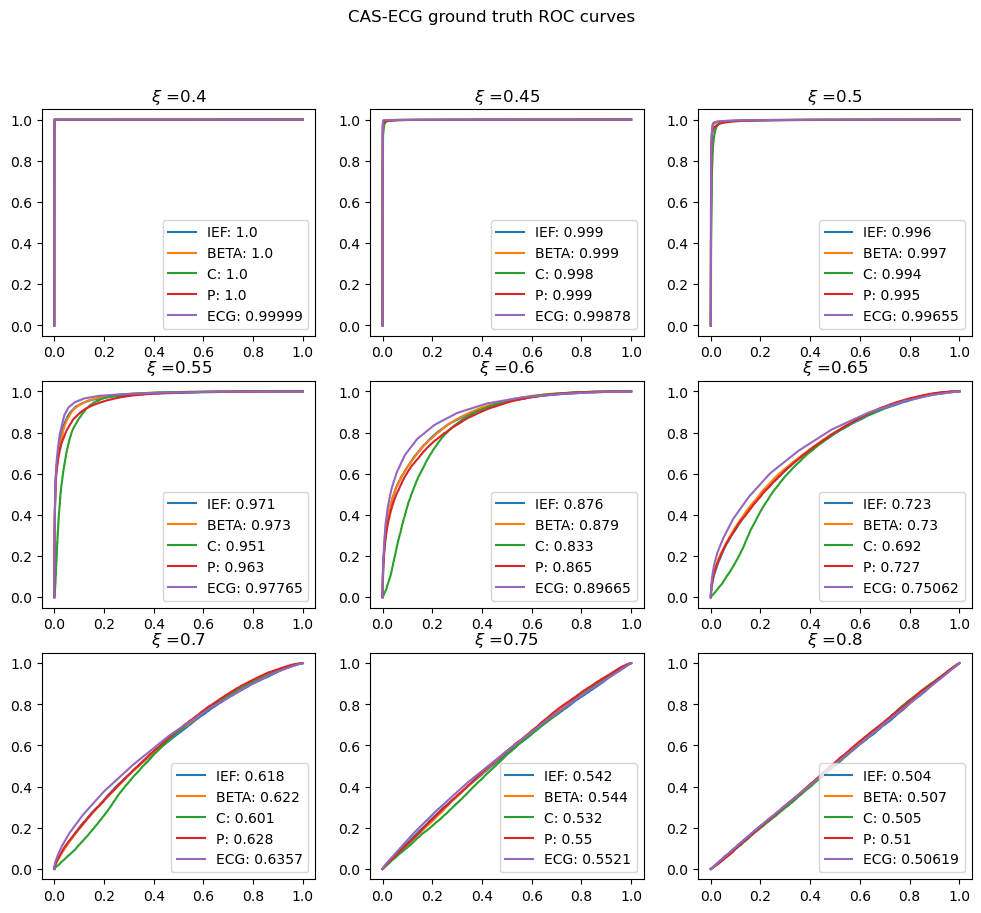

In [11]:
# ROC curves for edge weight predicting is-internal
XIs = [.4, .45, .5, .55, .6, .65, .7, .75, .8]
fig, axs = plt.subplots(3, 3, figsize=(12, 10))
for i in trange(len(XIs)):
    xi = XIs[i]
    plt.subplot(3,3,i+1)
    g = _run_julia_abcd(n=num_nodes, xi=xi, delta=delta, gamma=2.5, beta=1.5, zeta = 0.5, s=min_comm, tau = 0.767, nout=num_out)

    ief, beta, c, p, ecg = ecg_igraph.ensemble_cas_edge_weights(g, combine_function="min", clustering_method="first_louvain")
    is_internal = np.array([g.vs[e.source]["gt"] == g.vs[e.target]["gt"] for e in g.es], dtype="bool")

    fpr, tpr, thresholds = roc_curve(is_internal, ief, pos_label=1)
    plt.plot(fpr, tpr, label='IEF: '+str(round(AUC(is_internal, ief),3)))

    fpr, tpr, thresholds = roc_curve(is_internal, beta, pos_label=1)
    plt.plot(fpr, tpr, label='BETA: '+str(round(AUC(is_internal, beta),3)))

    fpr, tpr, thresholds = roc_curve(is_internal, c, pos_label=1)
    plt.plot(fpr, tpr, label='C: '+str(round(AUC(is_internal, c),3)))

    fpr, tpr, thresholds = roc_curve(is_internal, p, pos_label=1)
    plt.plot(fpr, tpr, label='P: '+str(round(AUC(is_internal, p),3)))

    fpr, tpr, thresholds = roc_curve(is_internal, ecg, pos_label=1)
    plt.plot(fpr, tpr, label='ECG: '+str(round(AUC(is_internal, ecg),5)))

    plt.title(r'$\xi$ ='+str(xi))
    plt.legend()
    

plt.suptitle("CAS-ECG ground truth ROC curves")

## A small benchmark for CAS-ECG clustering

In [8]:
## first with "mid-size" graphs
REP = 20
num_nodes = 2000
num_out = 0
delta = 5
min_comm = 100
alpha = 1

XIs = [.5, .525, .55, .575, .6, .65]
data = []
pbar = tqdm(total = len(XIs)*REP)
for xi, rep in product(XIs, range(REP)):
    g = _run_julia_abcd(n=num_nodes, xi=xi, delta=delta, gamma=2.5, beta=1.5, zeta = 0.5, s=min_comm, tau = 0.767)

    gt = np.array(g.vs["gt"])
    ief, beta, c, p, ecgw = ecg_igraph.ensemble_cas_edge_weights(g, combine_function="and")
    options = [
        ["IEF", ief],
        ["BETA", beta],
        ["C", c],
        ["P", p],
        ["ECG", ecgw]
    ]
    for name, edge_weights in options:
        clustering = ecg_igraph.cluster_edges(g, edge_weights).membership
        data.append([name, xi, AMI(gt, clustering)])
    
    # Include reference ecg implementation
    ref_ecg = g.community_ecg().membership
    data.append(["REF ECG", xi, AMI(gt, ref_ecg)])

    pbar.update()
pbar.close()

100%|██████████| 120/120 [40:59<00:00, 20.50s/it]


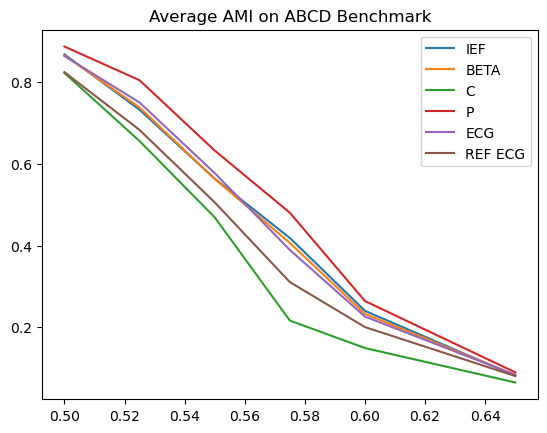

In [9]:
df = pd.DataFrame(data, columns=['name','xi','score'])
D = df.groupby(['name', "xi"])["score"].mean()

for name in df["name"].unique():
    xis = D[name].index.values
    scores = D[name].values
    plt.plot(xis, scores, label=name)
plt.title("Average AMI on ABCD Benchmark")
plt.legend()

In [10]:
for name in df["name"].unique():
    xis = D[name].index.values
    scores = D[name].values
    print(f"{name}: {scores}")

IEF: [0.86819238 0.73254698 0.56372154 0.41851484 0.2400396  0.08124072]
BETA: [0.86554489 0.73799915 0.56327063 0.40626027 0.23267353 0.08288796]
C: [0.82272941 0.6559048  0.46909728 0.21622252 0.14893561 0.06462138]
P: [0.88744183 0.80469985 0.63258233 0.48027658 0.26398183 0.08937369]
ECG: [0.86403908 0.75032987 0.57739839 0.38918353 0.22588968 0.08337229]
REF ECG: [0.82464266 0.6830734  0.50576473 0.31048822 0.200229   0.08038658]


## Refuse to Cluster Scores

100%|██████████| 16/16 [20:41<00:00, 77.59s/it]


Text(0.5, 0.98, 'Overall outlier scores')

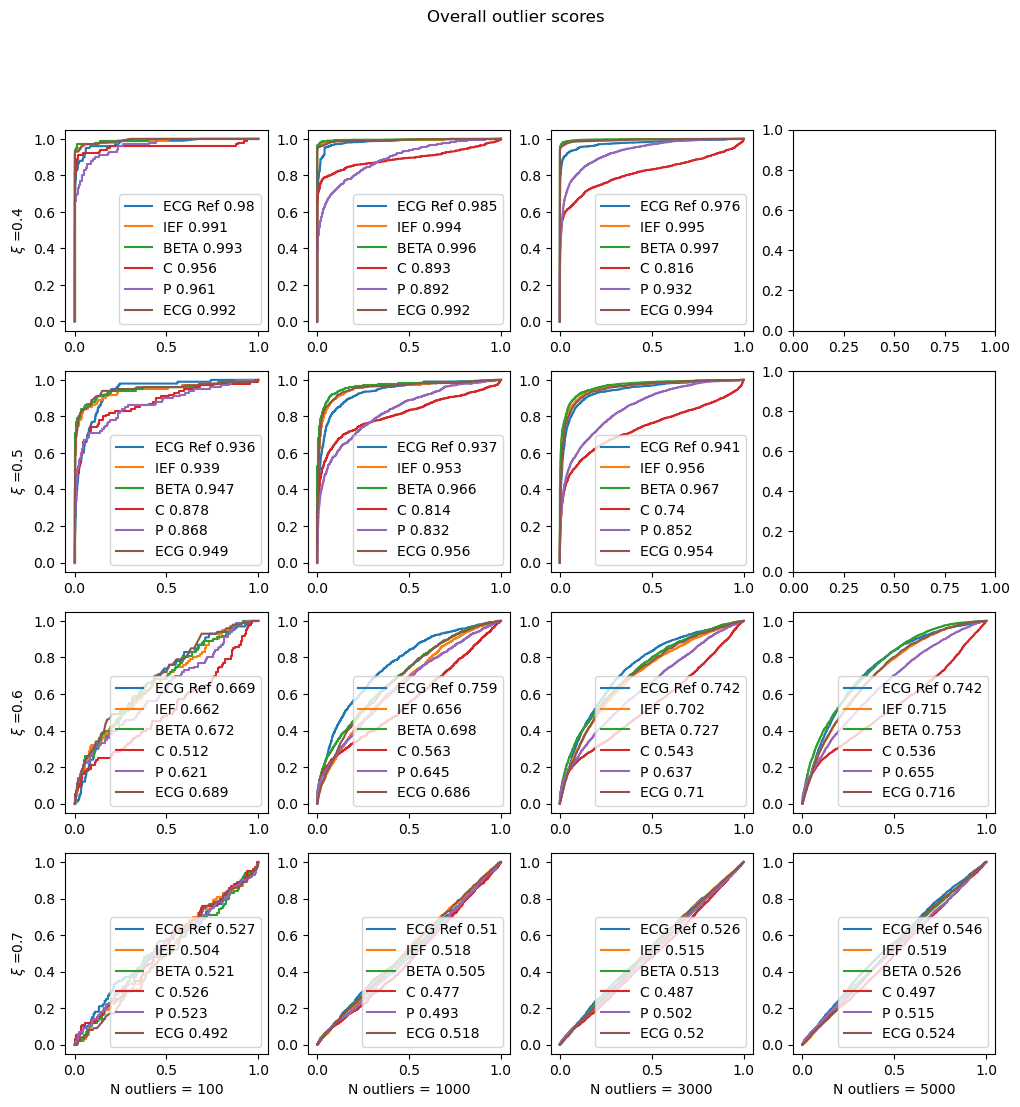

In [13]:
## first with "mid-size" graphs
num_nodes = 10000
num_out = 0
delta = 5
min_comm = 100
alpha = 1

XIs = [.4, .5, .6, .7]
pouts = [.01, .1, .3, .5]
fig, axs = plt.subplots(len(XIs), len(pouts), figsize=(12, 12))
for i in trange(len(XIs)*len(pouts)):
    row = i//len(XIs)
    col = i%len(pouts)

    if XIs[row] <= pouts[col]:
        continue

    xi = XIs[row]
    n_out = int(pouts[col]*num_nodes)
    g = _run_julia_abcd(n=num_nodes, xi=xi, delta=delta, gamma=2.5, beta=1.5, zeta = 0.5, s=min_comm, tau = 0.767, nout=n_out)
    ief, beta, c, p, ecg = ecg_igraph.ensemble_cas_edge_weights(g)
    is_outlier = np.array(g.vs["gt"]) == 0

    ecg_ref = g.community_ecg(refuse_score=True)
    clustering = ecg_ref.membership
    fpr, tpr, thresholds = roc_curve(is_outlier, ecg_ref.refuse_community, pos_label=1)
    axs[row, col].plot(fpr, tpr, label="ECG Ref "+str(round(AUC(is_outlier, ecg_ref.refuse_community),3)))

    options = [
        [ief, "IEF "],
        [beta, "BETA "],
        [c, "C "],
        [p, "P "],
        [ecg, "ECG "]
    ]
    for edge_weights, name in options:
        clustering = ecg_igraph.cluster_edges(g, edge_weights).membership
        outlier_score, _ = ecg_igraph.outlier_scores(g, edge_weights, clustering)
        fpr, tpr, thresholds = roc_curve(is_outlier, outlier_score, pos_label=1)
        axs[row, col].plot(fpr, tpr, label=name+str(round(AUC(is_outlier, outlier_score),3)))
    axs[row, col].legend()
    if row == len(XIs)-1:
        axs[row, col].set_xlabel(f"N outliers = "+str(n_out))
    if col == 0:
        axs[row, col].set_ylabel(r'$\xi$ =' +str(xi))
plt.suptitle("Overall outlier scores")


100%|██████████| 16/16 [23:30<00:00, 88.15s/it]


Text(0.5, 0.98, 'Community outlier scores')

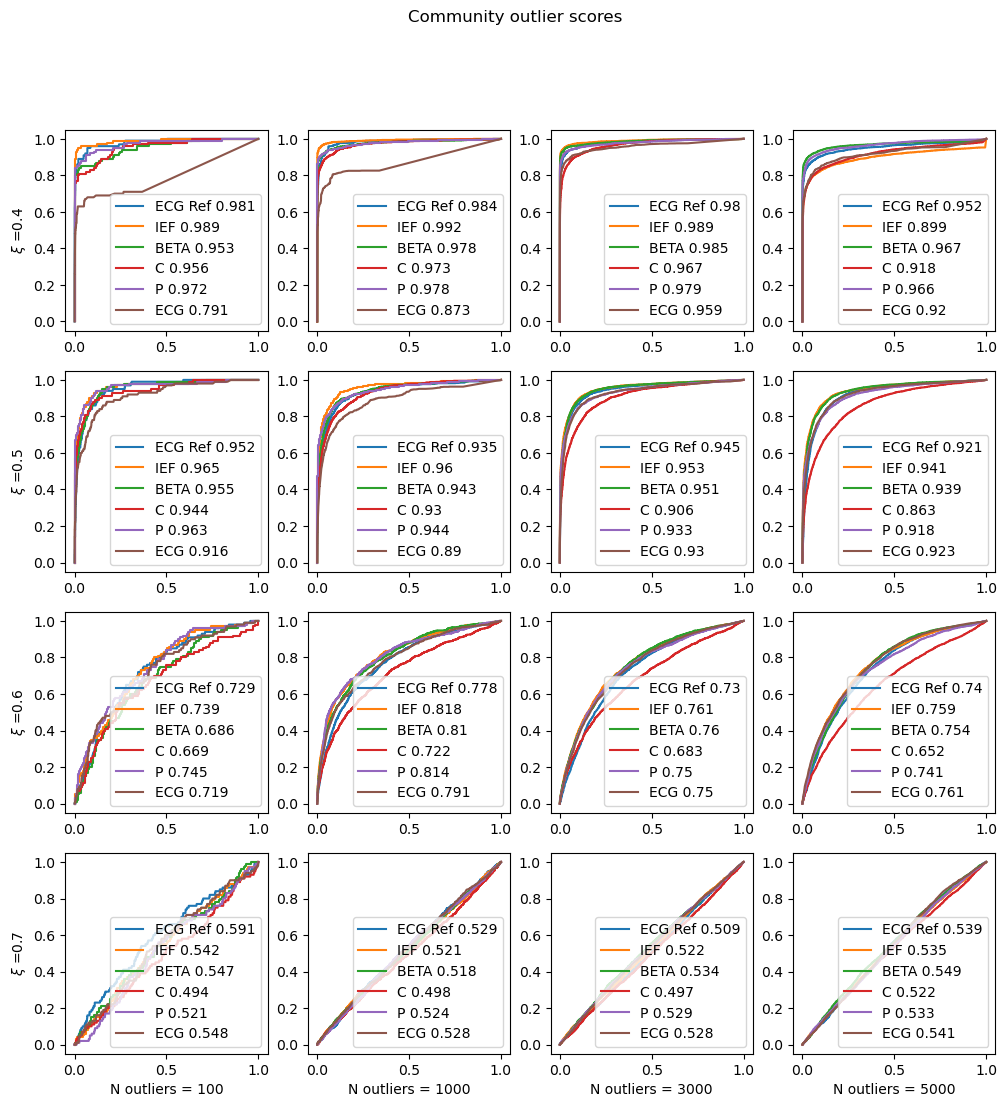

In [14]:
## first with "mid-size" graphs
num_nodes = 10000
num_out = 0
delta = 5
min_comm = 100
alpha = 1

XIs = [.4, .5, .6, .7]
pouts = [.01, .1, .3, .5]
fig, axs = plt.subplots(len(XIs), len(pouts), figsize=(12, 12))
for i in trange(len(XIs)*len(pouts)):
    row = i//len(XIs)
    col = i%len(pouts)
    xi = XIs[row]
    n_out = int(pouts[col]*num_nodes)
    g = _run_julia_abcd(n=num_nodes, xi=xi, delta=delta, gamma=2.5, beta=1.5, zeta = 0.5, s=min_comm, tau = 0.767, nout=n_out)
    ief, beta, c, p, ecg = ecg_igraph.ensemble_cas_edge_weights(g)
    is_outlier = np.array(g.vs["gt"]) == 0

    ecg_ref = g.community_ecg(refuse_score=True)
    clustering = ecg_ref.membership
    fpr, tpr, thresholds = roc_curve(is_outlier, ecg_ref.refuse_community, pos_label=1)
    axs[row, col].plot(fpr, tpr, label="ECG Ref "+str(round(AUC(is_outlier, ecg_ref.refuse_community),3)))
    
    options = [
        [ief, "IEF "],
        [beta, "BETA "],
        [c, "C "],
        [p, "P "],
        [ecg, "ECG "]
    ]
    for edge_weights, name in options:
        clustering = ecg_igraph.cluster_edges(g, edge_weights).membership
        _, outlier_score = ecg_igraph.outlier_scores(g, edge_weights, clustering)
        fpr, tpr, thresholds = roc_curve(is_outlier, outlier_score, pos_label=1)
        axs[row, col].plot(fpr, tpr, label=name+str(round(AUC(is_outlier, outlier_score),3)))
    axs[row, col].legend()
    if row == len(XIs)-1:
        axs[row, col].set_xlabel(f"N outliers = "+str(n_out))
    if col == 0:
        axs[row, col].set_ylabel(r'$\xi$ =' +str(xi))
plt.suptitle("Community outlier scores")

# A more comprehensive benchmark

To generate data, run the script ```benchmark.py```. It will likely take several hours.

In [ ]:
df = pd.read_feather("ecg_benchmarks.feather")
D = df.groupby(by=["name", "n_out", "task", "xi"])['score'].mean()
df["task"].unique()

In [ ]:
# Normalize plotting
def plot_task(task, D, ref="ECG", score="AUC"):
    n_outs = df["n_out"].unique()
    fig, axs = plt.subplots(1, len(n_outs), figsize=(20, 4))
    for name in ["BETA", "P", "C", "IEF", "ECG"]:
        for i, n_out in enumerate(n_outs):
            xis = D[name][n_out][task].index.values
            vals = D[name][n_out][task].values

            if ref is not None:
                ref_vals = D[ref][n_out][task].values
                vals = (vals-ref_vals)

            # chance = 0.5 if score == "AUC" else 0
            # bin_width = xis[1]-xis[0]
            # area_above_chance = np.sum((vals-chance)*bin_width) / ((1 - chance) * len(vals) * bin_width)
            # area_above_chance is a percentage of the area above the AUC=0.5 line out of the total possible area (where AUC is always 1)

            axs[i].plot(xis, vals, label=f"{name}")
            axs[i].legend()
            axs[i].set_xlabel(f"nout = {n_out}")
    axs[0].set_ylabel(score)
    plt.suptitle(task)

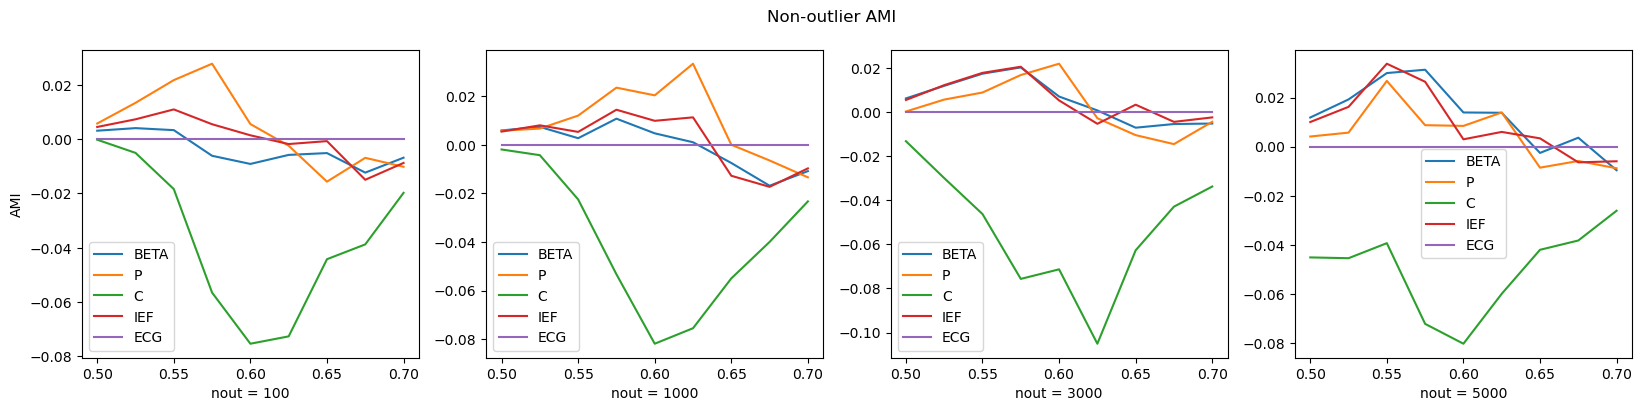

In [33]:
task = "Non-outlier AMI"
plot_task(task, D, score="AMI", ref="ECG")

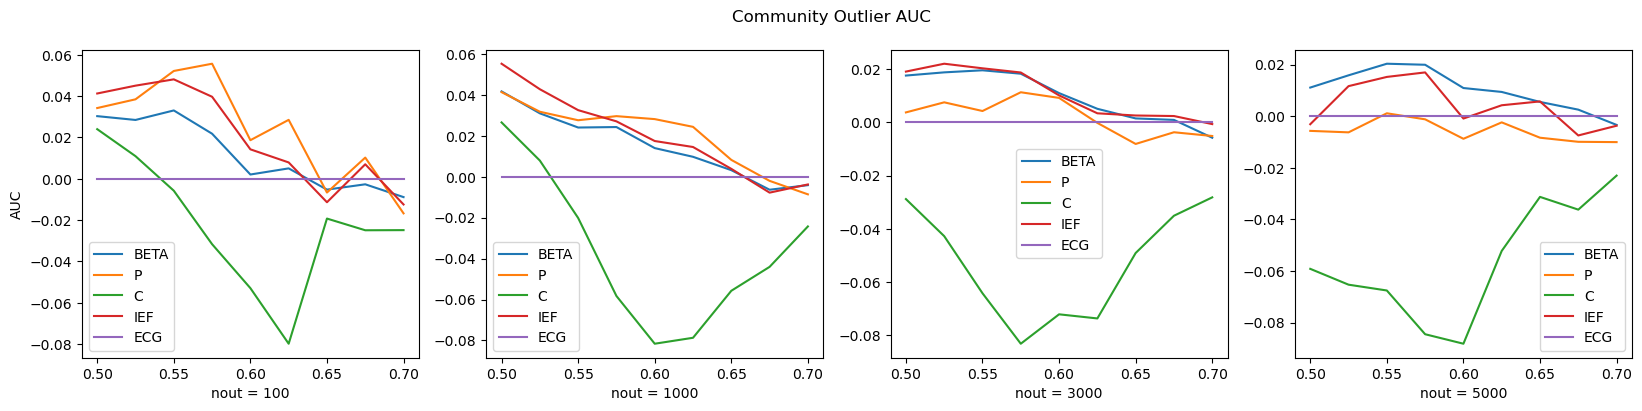

In [24]:
task = "Community Outlier AUC"
plot_task(task, D, ref="ECG")

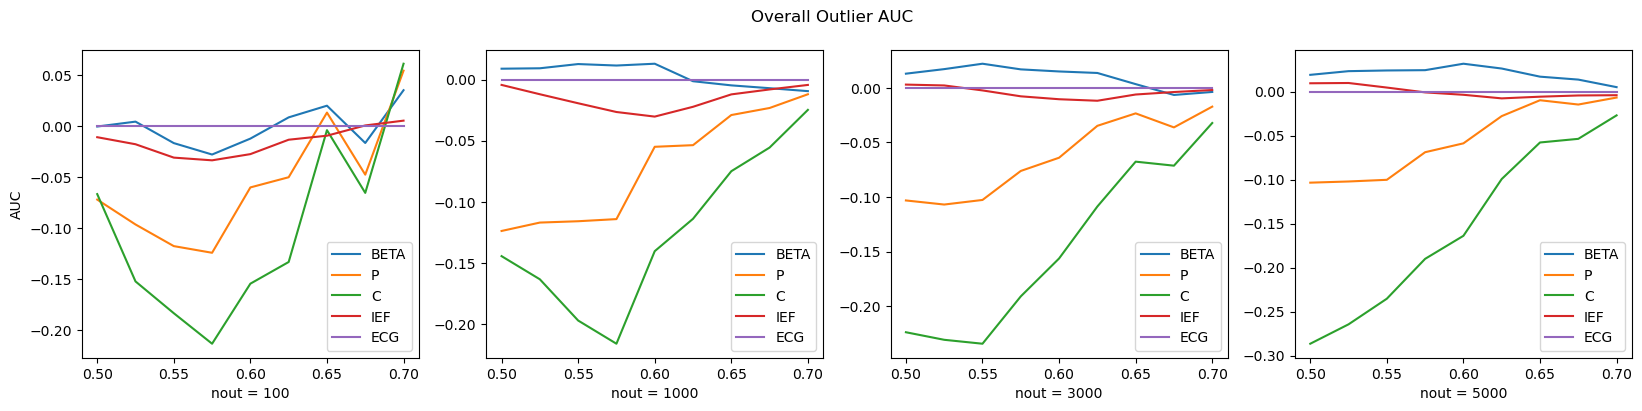

In [25]:
task = "Overall Outlier AUC"
plot_task(task, D, ref="ECG")

## CAS Outlier AUC's were backwards, so lower is actually better

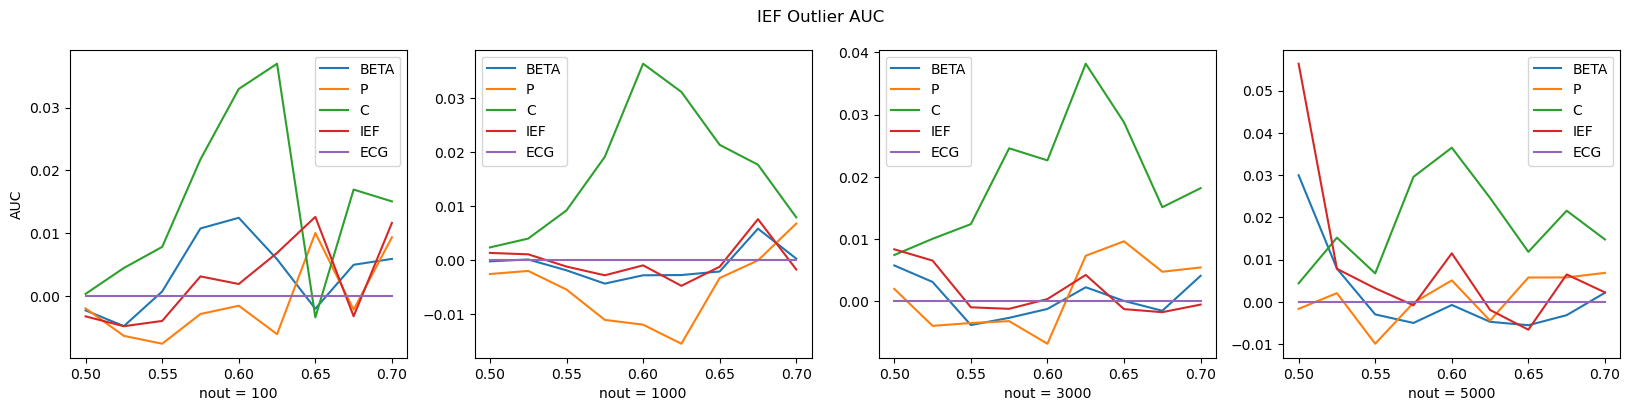

In [28]:
task = "IEF Outlier AUC"
plot_task(task, D, ref="ECG")

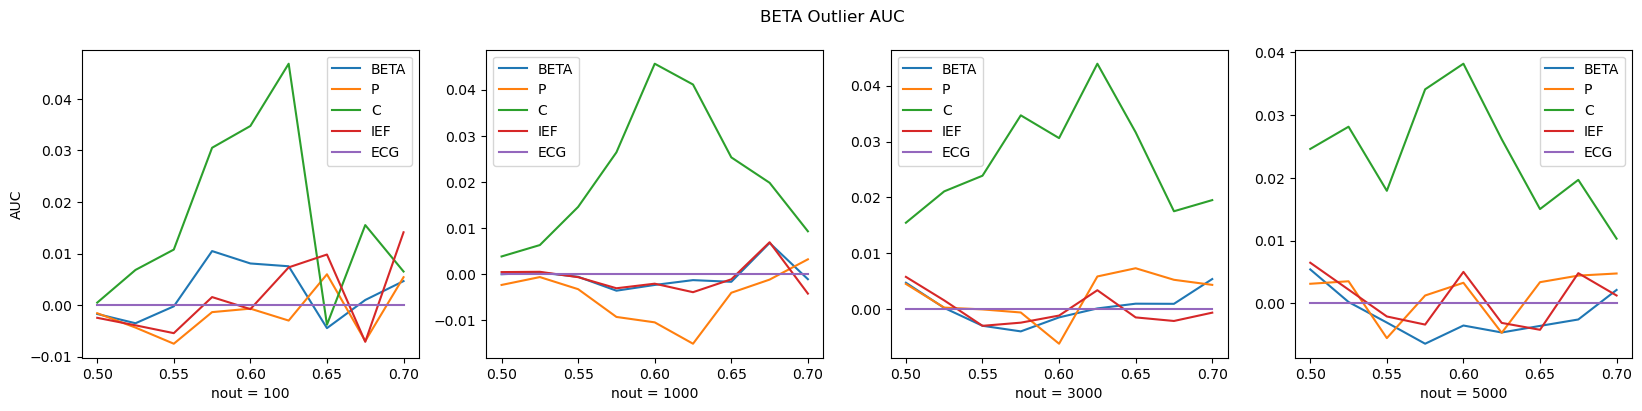

In [29]:
task = "BETA Outlier AUC"
plot_task(task, D, ref="ECG")

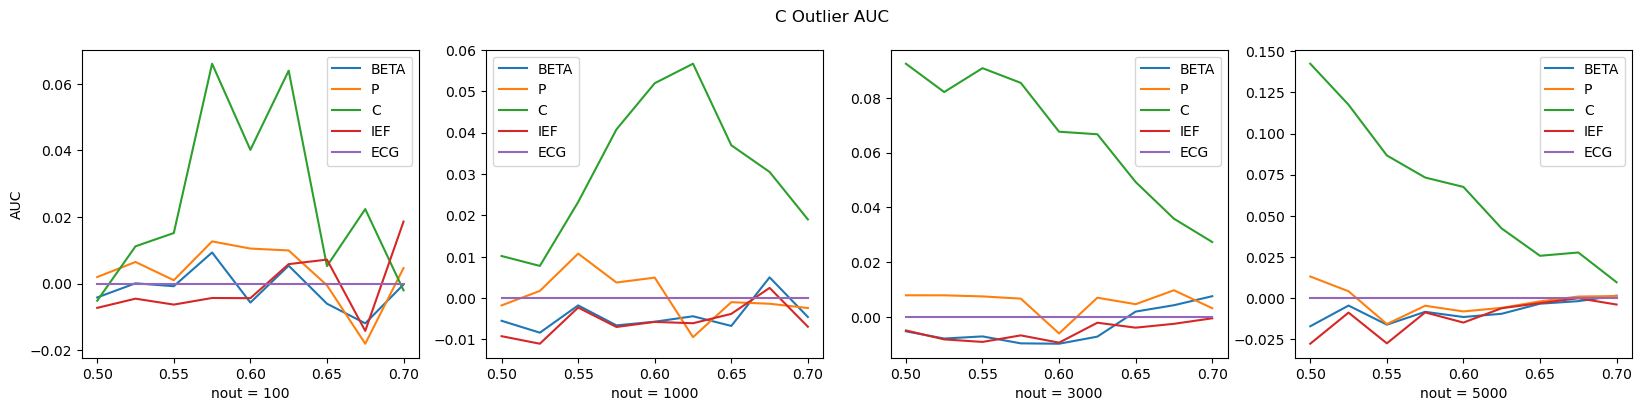

In [30]:
task = "C Outlier AUC"
plot_task(task, D, ref="ECG")


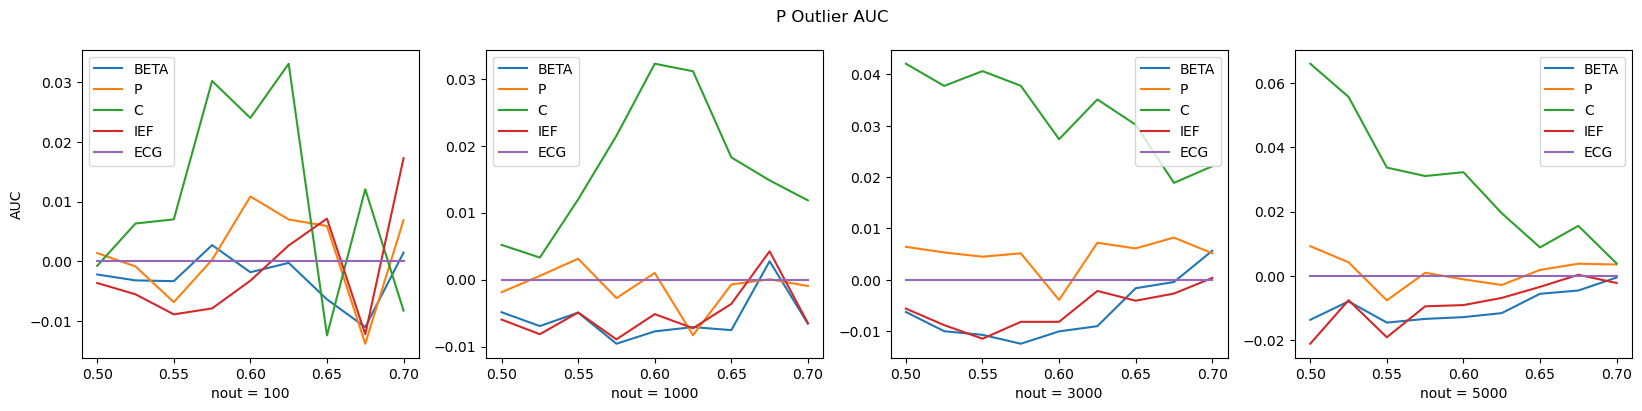

In [31]:
task = "P Outlier AUC"
plot_task(task, D, ref="ECG")

## Compare methods

In [61]:
def plot_name(name, D, ref=None, score="AUC"):
    n_outs = df["n_out"].unique()
    fig, axs = plt.subplots(1, len(n_outs), figsize=(20, 4))
    for task in ["Community Outlier AUC", "Overall Outlier AUC", "IEF Outlier AUC", "BETA Outlier AUC", "C Outlier AUC", "P Outlier AUC"]:
        for i, n_out in enumerate(n_outs):
            xis = D[name][n_out][task].index.values
            vals = D[name][n_out][task].values

            if task not in ["Community Outlier AUC", "Overall Outlier AUC"]:
                vals = 1-vals
            if ref is not None:
                ref_vals = D[name][n_out][ref].values
                if ref not in ["Community Outlier AUC", "Overall Outlier AUC"]:
                    ref_vals = 1-ref_vals
                vals = (vals-ref_vals)

            # chance = 0.5 if score == "AUC" else 0
            # bin_width = xis[1]-xis[0]
            # area_above_chance = np.sum((vals-chance)*bin_width) / ((1 - chance) * len(vals) * bin_width)
            # area_above_chance is a percentage of the area above the AUC=0.5 line out of the total possible area (where AUC is always 1)

            axs[i].plot(xis, vals, label=f"{task}")
            axs[i].legend()
            axs[i].set_xlabel(f"nout = {n_out}")
    axs[0].set_ylabel(score)
    plt.suptitle(f"Outlier detection methods for {name} clustering")

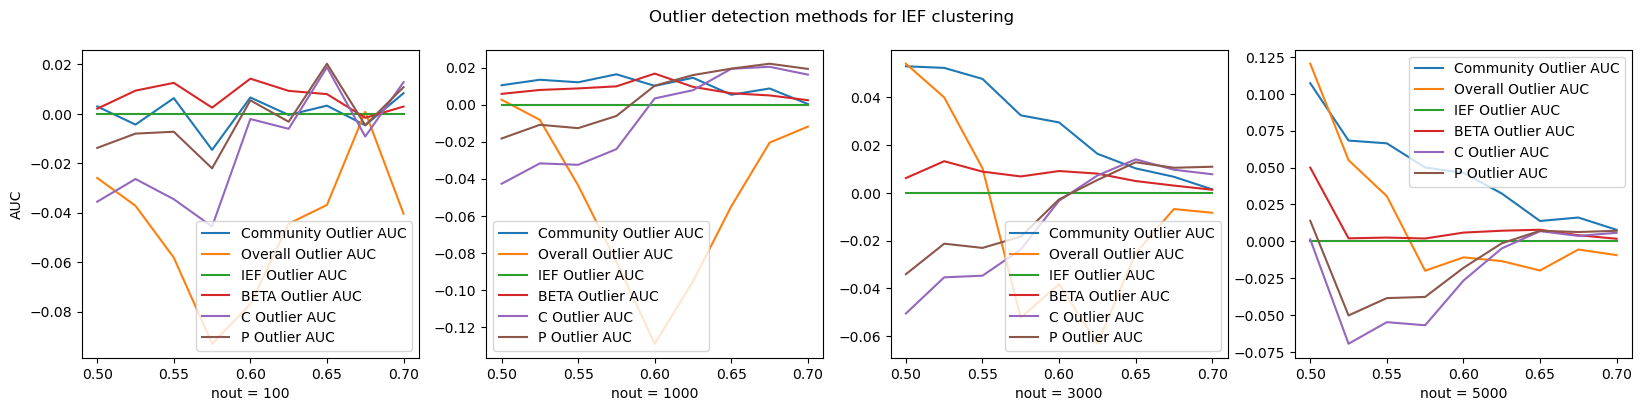

In [62]:
plot_name("IEF", D, ref="IEF Outlier AUC")


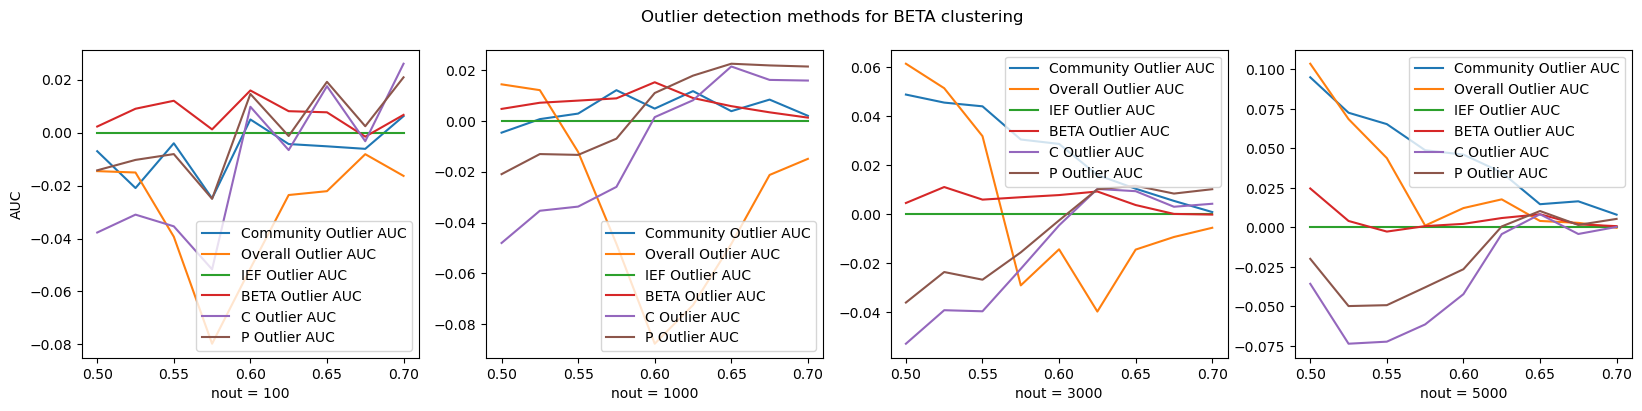

In [67]:
plot_name("BETA", D, ref="IEF Outlier AUC")


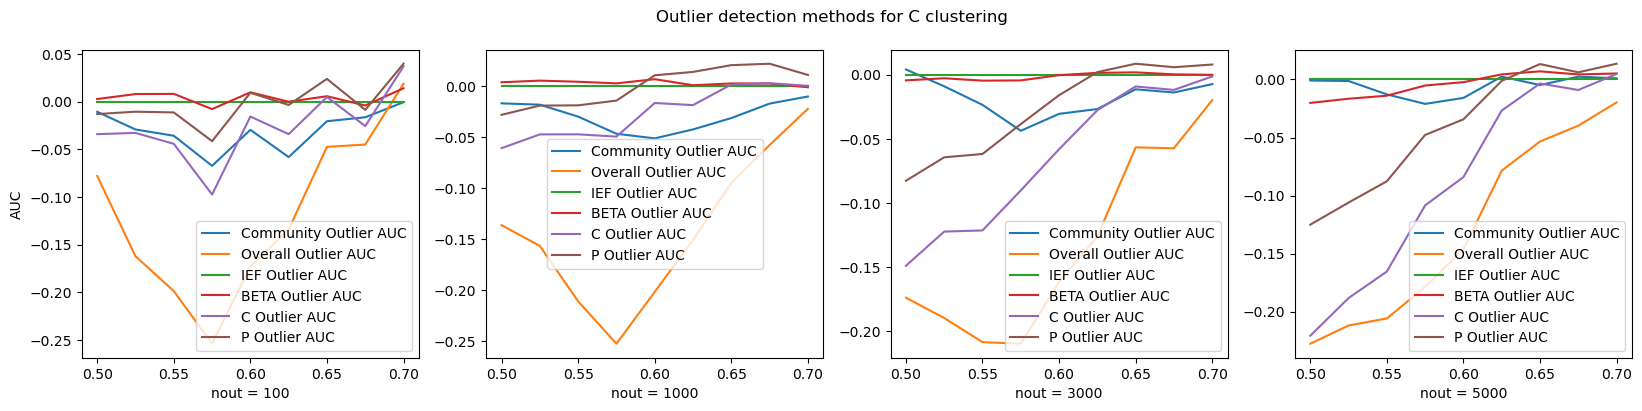

In [68]:
plot_name("C", D, ref="IEF Outlier AUC")

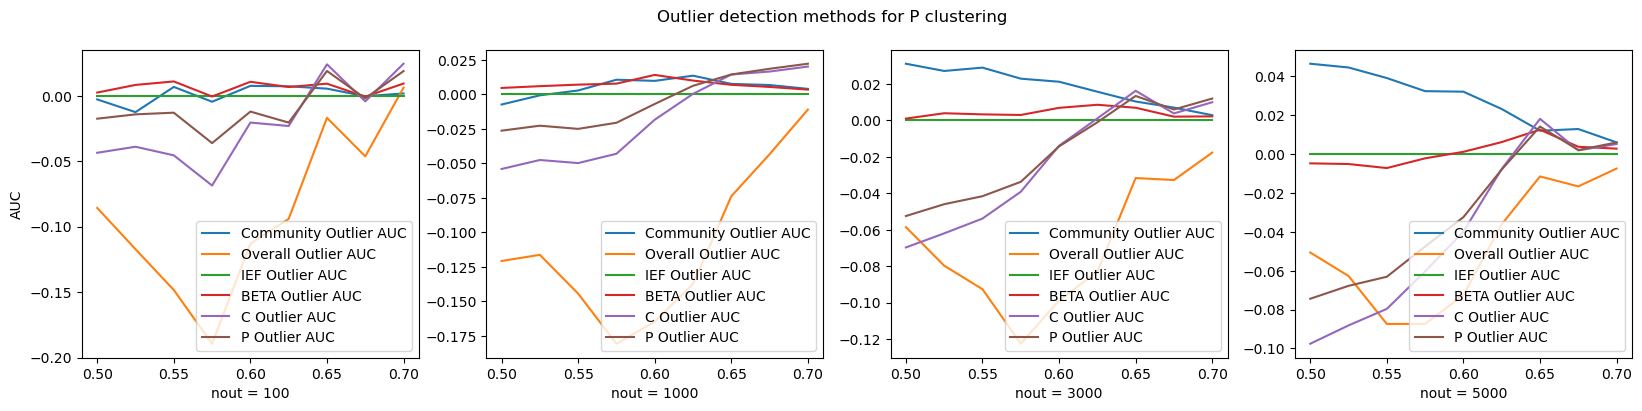

In [69]:
plot_name("P", D, ref="IEF Outlier AUC")

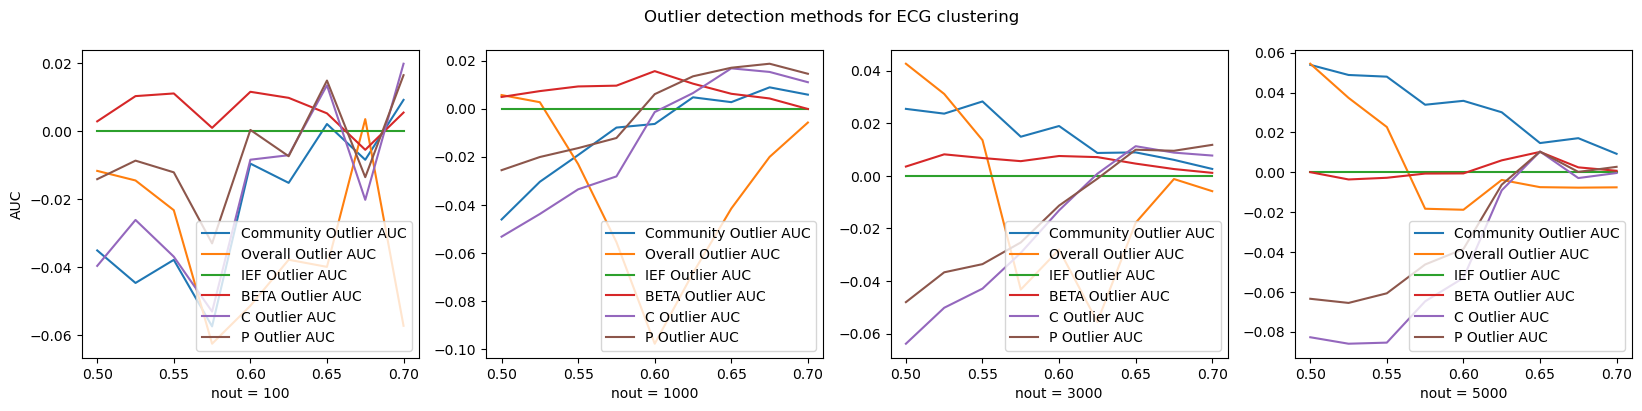

In [70]:
plot_name("ECG", D, ref="IEF Outlier AUC")